# Тематическая модель [Постнауки](http://postnauka.ru)
## Peer Review (optional)

В этом задании мы применим аппарат тематического моделирования к коллекции текстовых записей видеолекций, скачанных с сайта Постнаука. Мы будем визуализировать модель и создавать прототип тематического навигатора по коллекции. В коллекции 1728 документов, размер словаря - 38467 слов. Слова лемматизированы, то есть приведены к начальной форме, с помощью программы [mystem](https://tech.yandex.ru/mystem/), коллекция сохранена в [формате vowpal wabbit](http://docs.bigartm.org/en/latest/formats.html). В каждой строке до первой черты записана информация о документе (ссылка на страницу с лекцией), после первой черты следует описание документа. Используются две модальности - текстовая ("text") и модальность авторов ("author"); у каждого документа один автор.

Для выполнения задания понадобится библиотека [BigARTM](http://docs.bigartm.org). В демонстрации показан пример использования библиотеки версии 0.7.4, на сайте предлагается скачивать версию 0.8.0. В новой версии изменены принципы работы со словарями: они вынесены в отдельный класс (пример в [Release Notes](http://docs.bigartm.org/en/stable/release_notes/python.html)). Строить модель и извлекать ее параметры нужно так же, как показано в демонстрации. Вы можете использовать [предыдущий релиз](http://bigartm.readthedocs.io/en/v0.7.6/download.html) или [новый релиз](http://docs.bigartm.org/en/latest/download.html) на ваше усмотрение.

Спецификации всех функций вы можете смотреть на странице [Python API](http://bigartm.readthedocs.io/en/stable/python_interface.html).

In [1]:
import artm

In [2]:
from matplotlib import pyplot as plt
import seaborn
%matplotlib inline
seaborn.set_style("whitegrid", {'axes.grid' : False})

In [3]:
import numpy as np
import pandas as pd

##### Считывание данных

Создайте объект класса artm.BatchVectorizer, который будет ссылаться на директорию с пакетами данных (батчами). Чтобы библиотека могла преобразовать текстовый файл в батчи, создайте пустую директорию и укажите ее название в параметре target_folder. Размер батча для небольших коллекций (как наша) не важен, вы можете указать любой.

In [4]:
# Ваш код
batch_vectorizer = artm.BatchVectorizer(data_path="lectures.txt", data_format="vowpal_wabbit", target_folder="new_directory", 
                                       batch_size=100)

##### Инициализация модели

Создайте объект класса artm.Model с 30 темами, именами тем, указанными ниже и единичными весами обеих модальностей. Количество тем выбрано не очень большим, чтобы вам было удобнее работать с темами. На этой коллекции можно строить и большее число тем, тогда они будут более узко специализированы.

In [5]:
T = 30   # количество тем
topic_names=["sbj"+str(i) for i in range(T-1)]+["bcg"]
# Ваш код
model_artm = artm.ARTM(num_topics=T, topic_names=topic_names, class_ids={"text":1, "author" : 1}, 
                        cache_theta = True, reuse_theta = True)

Мы будем строить 29 предметных тем и одну фоновую. 

Соберите словарь с помощью метода gather_dictionary и инициализируйте модель, указав random_seed=1. Обязательно укажите свое название словаря, оно понадобится при добавлении регуляризаторов.

In [6]:
# Ваш код
np.random.seed(1)
dictionary = artm.Dictionary('postnauka_dictionary')
dictionary.gather(batch_vectorizer.data_path)
model_artm.initialize('postnauka_dictionary')

##### Добавление score

Создайте два измерителя качества artm.TopTokensScore - по одному для каждой модальности; количество токенов 15. Названия для score придумайте самостоятельно.

In [7]:
# Ваш код
model_artm.scores.add(artm.TopTokensScore(name="top_words", num_tokens=15, class_id="text"))
model_artm.scores.add(artm.TopTokensScore(name="top_authors", num_tokens=15, class_id="author"))

##### Построение модели

Мы будем строить модель в два этапа: сначала добавим сглаживающий регуляризатор фоновой темы и настроим параметры модели, затем - добавим разреживающий регуляризатор предметрых тем и выполним еще несколько итераций. Так мы сможем получить наиболее чистые от фоновых слов предметные темы. Сглаживающий и разреживающий регуляризаторы задаются одним и тем же классом artm.SmoothSparsePhiRegularizer: если коэффициент tau положительный, то регуляризатор будет сглаживающий, если отрицательный - разреживающий.

Если вы хотите подробнее разобраться, как выполняется регуляризация тематической модели в BigARTM, вы можете прочитать [статью](https://s3-eu-west-1.amazonaws.com/artm/voron-potap14artm-rus.pdf), раздел 4.

Добавьте сглаживающий регуляризатор с коэффициентом tau = 1e5, указав название своего словаря в dictionary, модальность текста в class_ids и тему "bcg" в topic_names.

In [8]:
# Ваш код
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(tau = 1e5, dictionary = dictionary, 
                                                            class_ids = "text", topic_names = "bcg"))


Выполните 30 итераций по коллекции (num_collection_passes), количество внутренних итераций установите равным 1. Используйте метод fit_offline модели.

In [9]:
# Ваш код
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=30)

Добавьте разреживающий регуляризатор с коэффициентом tau=-1e5, указав название своего словаря, модальность текста в class_ids и все темы "sbjX" в topic_names.

In [10]:
# Ваш код
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(tau = -1e5, dictionary = dictionary, 
                                                            class_ids = "text", topic_names = topic_names[:-1]))

Выполните еще 15 проходов по коллекции.

In [11]:
# Ваш код
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

##### Интерпретация тем

Используя созданные score, выведите топы слов и топы авторов в темах. Удобнее всего выводить топ слов каждой темы с новой строки, указывая название темы в начале строки, и аналогично с авторами.

In [12]:
# Ваш код
for topic_name in model_artm.topic_names:
    string = topic_name + ': '
    tokens = model_artm.score_tracker["top_words"].last_tokens
    for word in tokens[topic_name]:    
        string+= word+" "
    print(string)


sbj0: власть русь александр церковь император закон средневековый святой сага князь король римский папа византийский знаменитый 
sbj1: звезда планета земля атмосфера солнце нейтронный вокруг белый карлик образовываться газ вещество тело солнечный диск 
sbj2: система общий поведение движение трудность двигаться относительность разрабатывать ответ парадокс интеллект специальный допускать задание тест 
sbj3: культура рассказывать понятие кандидат доктор каков культурный восприятие сознание особенность феномен признак личность воспринимать изменение 
sbj4: право вещь правовой римский должник юрист собственность обязательство качество владение требование юридический собственник критерий кредитор 
sbj5: свет углеродный оптический солнечный электронный устройство энергетика микроскоп прибор нитрид кремний машина транзистор бор электричество 
sbj6: фильм литература написать литературный книга тема автор кино выходить писать роман кинематограф произведение жанр герой 
sbj7: ритуал смерть госуда

In [13]:
for topic_name in model_artm.topic_names:
    string = topic_name + ': '
    tokens = model_artm.score_tracker["top_authors"].last_tokens
    for word in tokens[topic_name]:    
        string+= word+" "
    print(string)

sbj0: Александр_Марей Фёдор_Успенский Татьяна_Бобровникова Алексей_Юдин Игорь_Данилевский Павел_Уваров Владимир_Петрухин Елена_Уханова Ольга_Брилева Олег_Воскобойников Елена_Браун Григорий_Бондаренко Екатерина_Болтунова Ольга_Тогоева Ольга_Вайнштейн 
sbj1: Сергей_Попов Дмитрий_Вибе Дмитрий_Титов Валерий_Сулейманов Владимир_Кузнецов Зоригто_Намсараев Николай_Дронин Роман_Рафиков Наталья_Новикова Елизавета_Ривкина Александр_Потехин Александр_Слободкин Александр_Марков Армен_Мулкиджанян Андрей_Глазовский 
sbj2: Владимир_Мележик Александр_Поддьяков Михаил_Пантелеев Эмиль_Ахмедов Инга_Полетаева Алексей_Акимов Антон_Суворов Владимир_Редько Михаил_Фейгельман Даниэль_Сельва Василий_Климов Владимир_Шалаев Алексей_Желтиков Илья_Щуров Татьяна_Клячко 
sbj3: Виталий_Куренной Михаил_Соколов Ольга_Артёмова Алексей_Руткевич Дмитрий_Громов Пётр_Турчин Сергей_Арутюнов Владимир_Миронов Андрей_Лукашов Владимир_Бобровников Кирилл_Разлогов Максим_Кронгауз Татьяна_Смоктунович Ирина_Савельева Владимир_Каганск

В последней теме "bcg" должны находиться общеупотребительные слова.

Важный шаг в работе с тематической моделью, когда речь идет о визуализации или создании тематического навигатора, это именование тем. Понять, о чем каждая тема, можно по списку ее топовых слов. Например, тему
    
    частица взаимодействие физика кварк симметрия элементарный нейтрино стандартный материя протон бозон заряд масса ускоритель слабый
    
можно назвать "Физика элементарных частиц". 

Дайте названия 29 предметным темам. Если вы не знаете, как назвать тему, назовите ее первым встретившимся в ней существительным, хотя при таком подходе навигатор будет менее информативным. Из названий тем составьте список из 29 строк и запишите го в переменную sbj_topic_labels. В переменной topic_labels будут храниться названия всех тем, включая фоновую.

In [14]:
sbj_topic_labels = ["Церковь", "Планеты", "Движение",
                   "Культура", "Юриспруденция", "Материал", "Искусство", "Идеология", 
                    "Химия", "Квантовая физика", "ВОВ", "Семья", "Заболевания", "Религия", "Астрономия", 
                    "Информатика", "Рассы", "Политика", "Русский язык", "История", "Урбанистика", 
                    "Лечение", "Социология", "МЛ", "Мифология", "Лингвистика", "Экономика",
                    "Гинетика", "Сверхпроводники"   
                   ]   # запишите названия тем в список
topic_labels = sbj_topic_labels + ["Фоновая тема"]

##### Анализ тем

Далее мы будем работать с распределениями тем в документах (матрица $\Theta$) и авторов в темах (одна из двух матриц $\Phi$, соответствующая модальности авторов). 
Создайте переменные, содержащие две этих матрицы, с помощью методов get_phi и get_theta модели. Назовите переменные theta и phi_a. Выведите формы обеих матриц, чтобы понять, по каким осям стоят темы.

In [15]:
model_artm.theta_columns_naming = "title" # включает именование столбцов Theta их названиями-ссылками, а не внутренними id 
# Ваш код
theta = model_artm.get_theta(topic_names)
phi_a = model_artm.get_phi(topic_names = topic_names, class_ids="author")
print(theta.shape)
print(phi_a.shape)

(30, 1728)
(539, 30)


Визуализируем фрагмент матрицы $\Theta$ - первые 100 документов (это наиболее простой способ визуально оценить, как темы распределяются в документах). С помощью метода seaborn.heatmap выведите фрагмент theta как изображение. Рекомендация: создайте фигуру pyplot размера (20, 10).

In [16]:
theta[theta.columns[:10]]

,http://postnauka.ru/video/56293,http://postnauka.ru/video/56295,http://postnauka.ru/video/56297,http://postnauka.ru/video/56300,http://postnauka.ru/video/56302,http://postnauka.ru/video/56304,http://postnauka.ru/video/56306,http://postnauka.ru/video/5633,http://postnauka.ru/video/56616,http://postnauka.ru/video/56618
sbj0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.657054,0.000000,0.000000
sbj1,0.043800,0.000000,0.000000,0.062278,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sbj2,0.000000,0.000000,0.000000,0.266926,0.000000,0.000000,0.000000,0.000000,0.000000,0.601372
sbj3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.076087,0.000000,0.000000
sbj4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sbj5,0.000000,0.000000,0.000000,0.010265,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sbj6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.585691,0.000000,0.000000,0.000000
sbj7,0.000000,0.000000,0.000000,0.000000,0.000000,0.038749,0.000000,0.000000,0.000000,0.000000
sbj8,0.233026,0.780488,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.060750,0.000000
sbj9,0.222804,0.175769,0.134129,0.373070,0.000000,0.000000,0.055597,0.000000,0.081175,0.000000


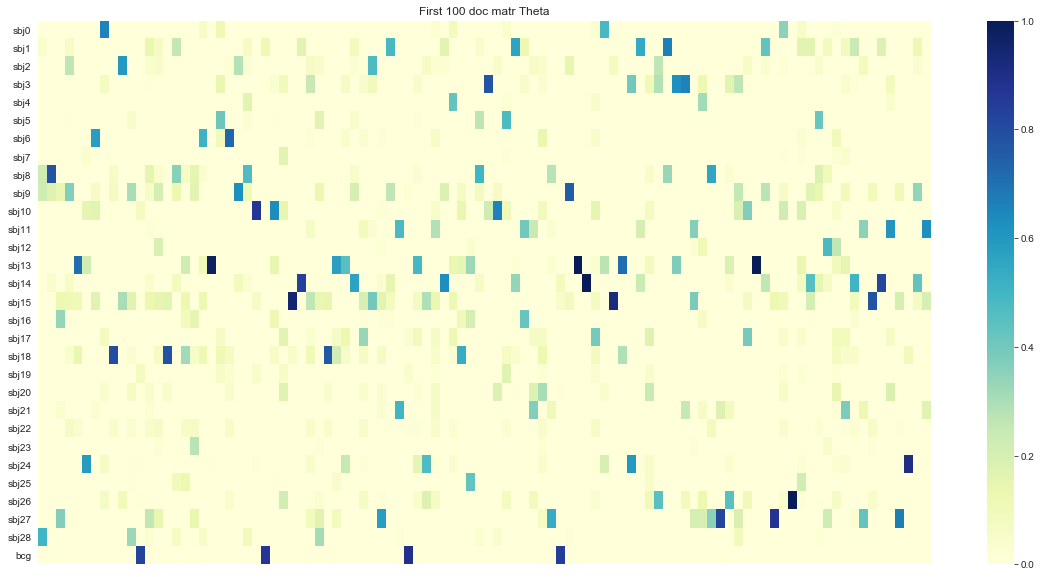

In [24]:
# Ваш код

plt.figure(figsize=(20,10))
plt.title('First 100 doc matr Theta')
seaborn.heatmap(theta.iloc[:, :100], xticklabels = False, cmap="YlGnBu")
plt.show()

Вы должны увидеть, что фоновая тема имеет большую вероятность в почти каждом документе, и это логично. Кроме того, есть еще одна тема, которая чаще других встречается в документах. Судя по всему, это тема содержит много слов по науку в целом, а каждый документ (видео) в нашей коллекции связан с наукой. Можно (необязательно) дать этой теме название "Наука".

Помимо этих двух тем, фоновой и общенаучной, каждый документ характеризуется малым числом других тем.

Оценим $p(t)$ - долю каждой темы во всей коллекции. По формуле полной вероятности вычислять эти величины нужно как
$p(t) = \sum_d p(t|d) p(d)$. Согласно вероятностной модели, $p(d)$ пропорционально длине документа d. Поступим проще: будем полагать, что все документы равновероятны. Тогда оценить $p(t)$ можно, просуммировав $p(t|d)$ по всем документам, а затем разделив полученный вектор на его сумму. 

Создайте переменную-датафрейм с T строками, индексированными названиями тем, и 1 столбцом, содержащим оценки $p(t)$. Выведите датафрейм на печать.

In [73]:
theta.sum().sum()

1728.0

In [25]:
# Ваш код

d = {"p(t)" : [theta.iloc[i].sum()/theta.sum().sum() for i in range(theta.shape[0])]}


prob = pd.DataFrame(d, index = topic_labels)

In [26]:
prob

,p(t)
Церковь,0.028595
Планеты,0.037141
Движение,0.019292
Культура,0.066504
Юриспруденция,0.020706
Материал,0.014873
Искусство,0.023431
Идеология,0.009660
Химия,0.047139
Квантовая физика,0.067615


Найдите 5 самых распространенных и 3 наименее освещенных темы в коллекции (наибольшие и наименьшие $p(t)$ соответственно), не считая фоновую и общенаучную. Укажите названия, которые вы дали этим темам.

In [27]:
prob.sort_values("p(t)")

,p(t)
Идеология,0.009660
Лингвистика,0.010299
Рассы,0.013873
История,0.014279
Материал,0.014873
Фоновая тема,0.016456
Сверхпроводники,0.016496
Заболевания,0.017401
МЛ,0.017512
Движение,0.019292


Визуализируйте матрицу $\Phi$ модальности авторов в виде изображения. Рекомендация: установите yticklabels=False в heatmap.

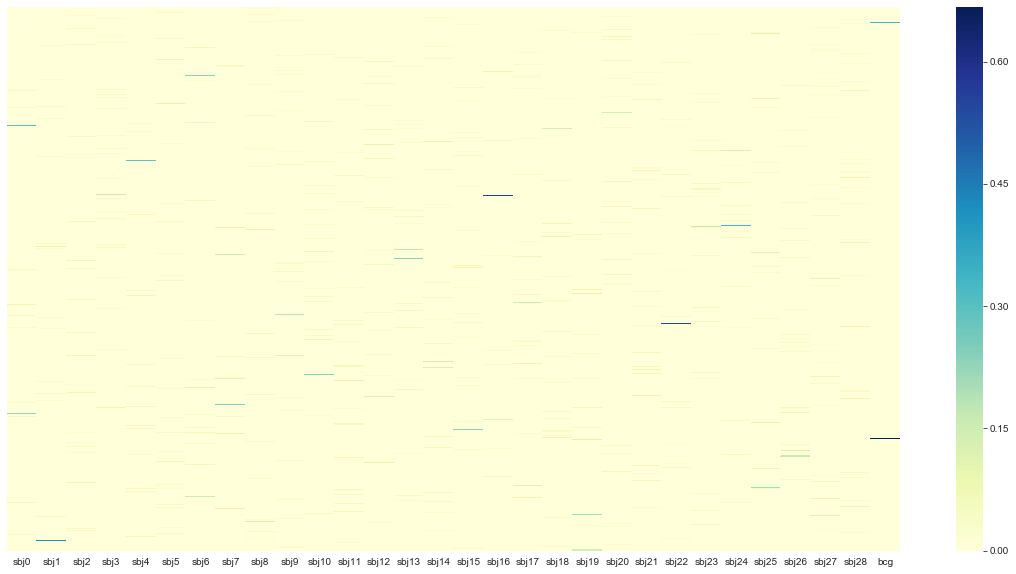

In [28]:
# Ваш код
fig = plt.figure(figsize=(20,10))
seaborn.heatmap(phi_a, yticklabels=False, cmap="YlGnBu")

Каждой теме соответствует не очень большое число авторов - матрица достаточно разреженная. Кроме того, некоторые темы имеют доминирующего автора $a$, имеющего большую вероятность $p(a|t)$ - этот автор записал больше всего лекций по теме. 

Будем считать, что автор $a$ значим в теме, если $p(a|t) > 0.01$. Для каждого автора посчитайте, в скольких темах он значим. Найдите авторов-рекордсменов, которые значимы (а значит, читали лекции) в >= 3 темах.

In [29]:
authors_contributuin = np.zeros(phi_a.shape[0])
for i in range(phi_a.shape[0]):
    authors_contributuin[i] = len(phi_a.iloc[i][phi_a.iloc[i] > 0.01])

In [32]:
idx = np.linspace(0, len(authors_contributuin)-1, len(authors_contributuin), dtype = int)
idx = idx[authors_contributuin > 2]
for i in idx:
    print(phi_a.index[i][1])

Илья_Иткин
Ольга_Тогоева
Андрей_Цатурян
Иван_Воробьев
Екатерина_Лямина
Илья_Щуров
Олег_Воскобойников
Алина_Бодрова
Петр_Федичев
Михаил_Алексеевский
Михаил_Соколов
Ольга_Вайнштейн
Михаил_Маяцкий
Павел_Нерлер_(Полян)
Андрей_Кофман
Шринивас_Шридхар


Большинство авторов значимы в 1 теме, что логично.

##### Построение тематической карты авторов

По сути, в матрице $\Phi$, соответствующей модальности авторов, записаны тематические кластеры авторов. Для любого автора мы можем составить его тематический круг - авторов, разбирающихся в той же теме, что и данный. Интересующиеся слушатели могут попробовать выполнить эту процедуру для ученых, читающих лекции на Постнауке, которых они знают (например, на Постнауке есть лекции с К. В. Воронцовым - лектором текущего модуля :)

Составим карту близости авторов по тематике их исследований. Для этого применим метод понижения размерности MDS к тематическим профилям авторов.

Чтобы получить тематический профиль автора, распределение $p(t|a)$, нужно воспользоваться формулой Байеса: 
$p(t|a) = \frac {p(a|t) p(t)} {\sum_t' p(a|t') p(t')}$. Все необходимые для этого величины у вас есть и записаны в переменных phi и pt. 

Передайте матрицу тематических профилей авторов, записанных по строкам, в метод MDS с n_components=2. Используйте косинусную метрику (она хорошо подходит для поиска расстояний между векторами, имеющими фиксированную сумму компонент).

In [33]:
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances

In [34]:
# Ваш код
Thema_author = np.zeros(phi_a.shape)

for i in range(phi_a.shape[0]):
    for j in range(phi_a.shape[1]):
        Thema_author[i][j] = phi_a.iloc[i][j]*prob.iloc[j]/(np.array(phi_a.iloc[i])*np.array(prob["p(t)"])).sum()

In [35]:
md = MDS(n_components = 2, metric="cosine")

a = md.fit_transform(Thema_author)


Визуализируйте найденные двумерные представления с помощью функции scatter. 

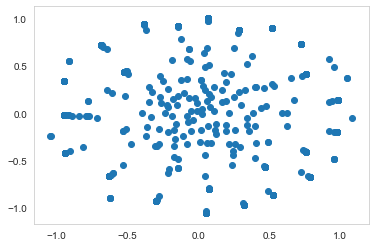

In [36]:
# Ваш код
plt.scatter(a[:, 0], a[:,1])

Должно получиться, что некоторые грппы авторов формируют сгустки, которые можно считать тематическими группами авторов.

Раскрасим точки следующим образом: для каждого автора выберем наиболее вероятную для него тему ($\max_t p(t|a)$), и каждой теме сопоставим цвет. Кроме того, добавим на карту имена и фамилии авторов, это можно сделать в цикле по всем точкам с помощью функции plt.annotate, указывая метку точки первым аргументом и ее координаты в аргументе xy. Рекомендуется сделать размер изображения большим, тогда маркеры точек тоже придется увеличить (s=100 в plt.scatter). Изобразите карту авторов и сохраните в pdf-файл с помощью функции plt.savefig. 

Метки авторов будут пересекаться. Будет очень хорошо, если вы найдете способ, как этого можно избежать.

('author', 'Сергей_Деев')

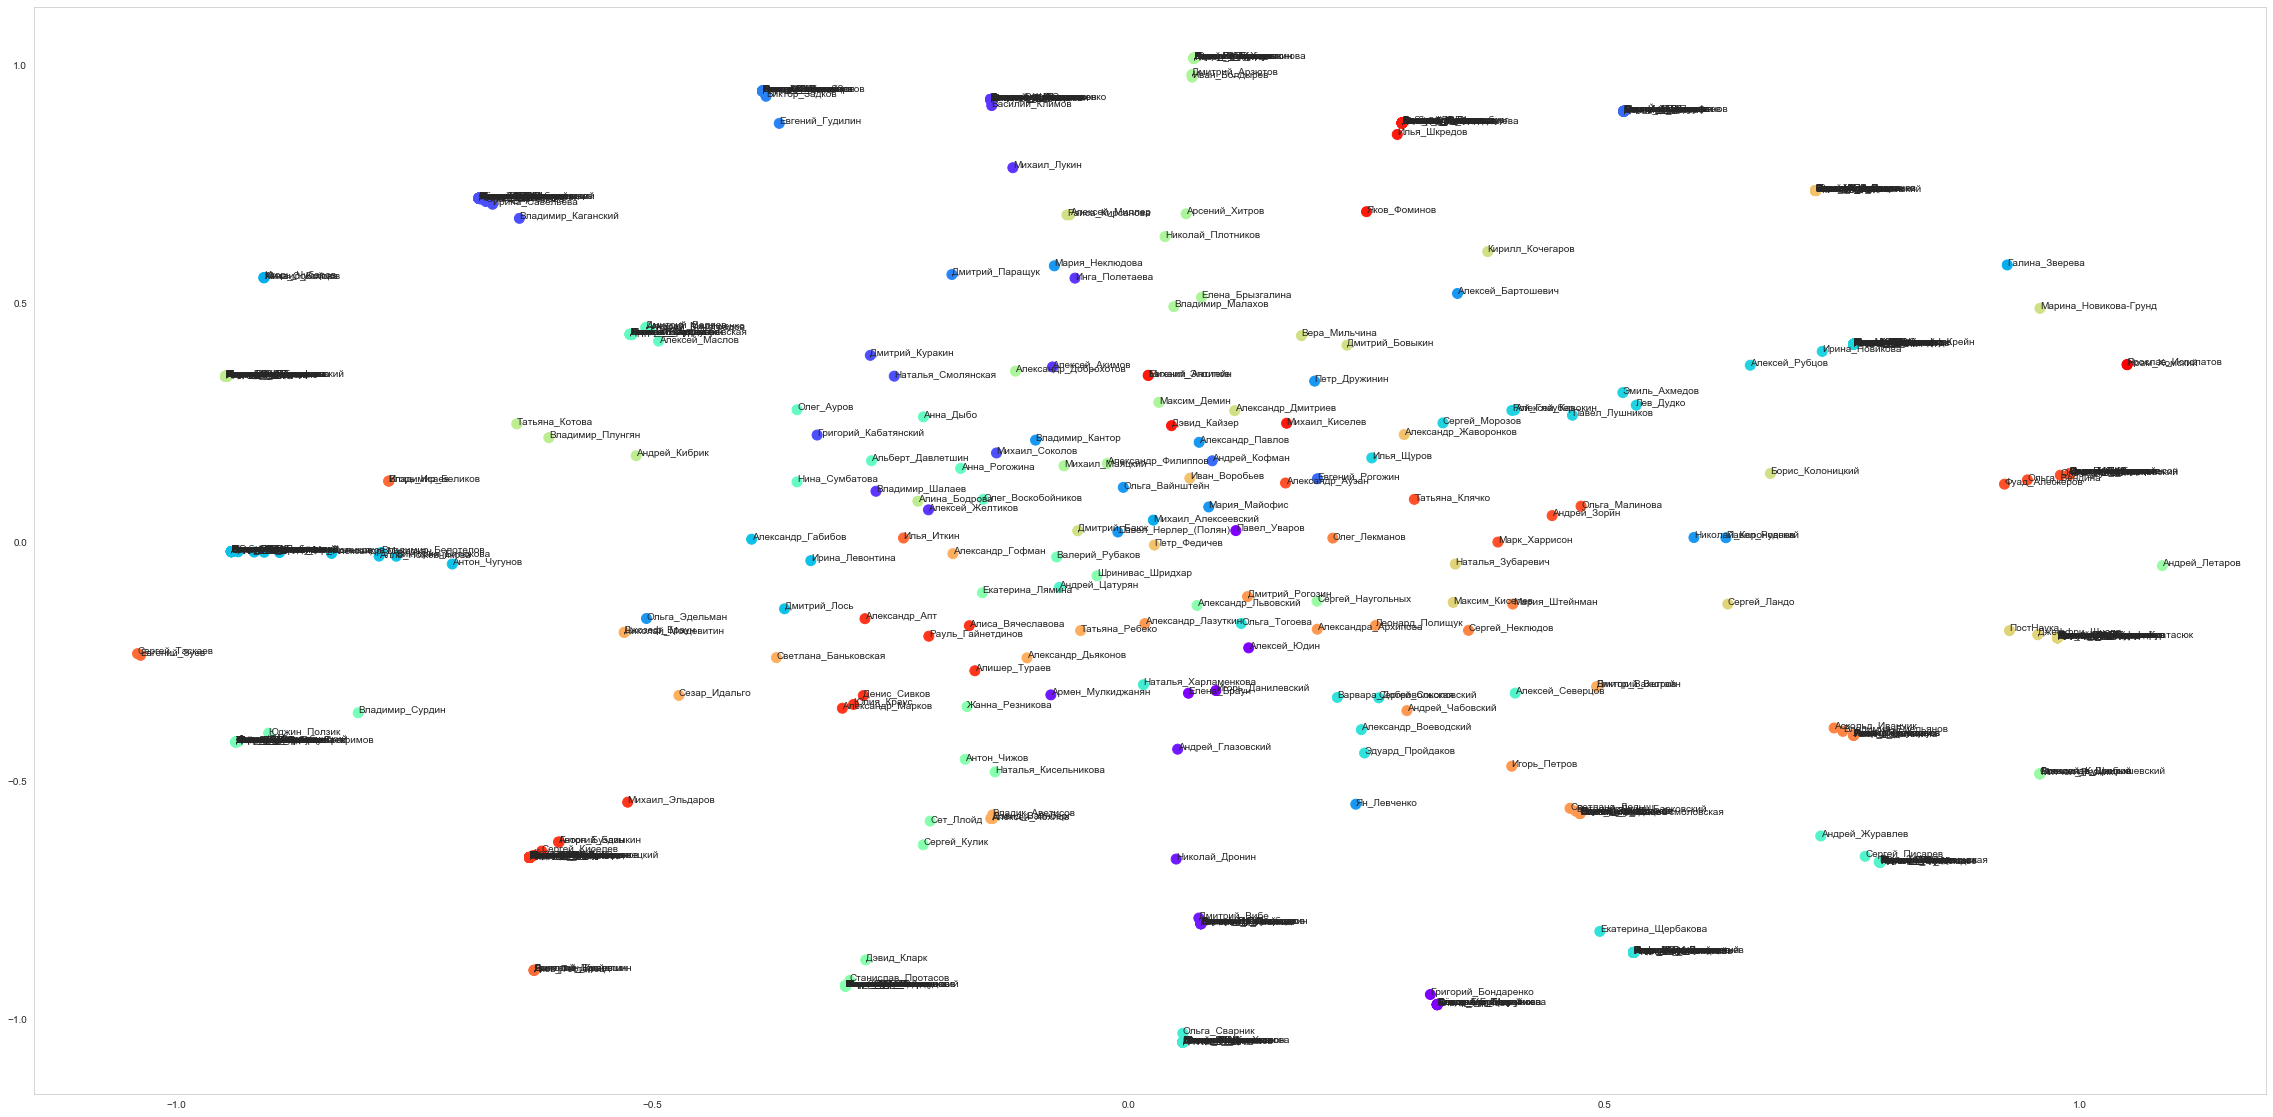

In [42]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, T)) # цвета для тем
# Ваш код
authors = []

for i in range(phi_a.shape[0]):
    authors.append(colors[np.where(Thema_author[i] == Thema_author[i].max())[0][0]] )   
plt.figure(figsize=(40,20))
plt.scatter(a[:, 0], a[:,1], color = authors, s = 100)
for i, author in enumerate(phi_a.index):
    plt.annotate(s = author[1], xy = [a[i][0], a[i][1]]
                 
                )
    
plt.savefig("Distribution.pdf")

##### Создание простого тематического навигатора по Постнауке

Наш тематический навигатор будет для каждой темы показывать ее список слов, а также список релевантных теме документов. 

Нам понадобятся распределения $p(d|t)$. По формуле Байеса $p(d|t) = \frac{p(t|d)p(d)}{\sum_{d'}p(t|d')p(d')}$, но поскольку мы считаем документы равновероятными, достаточно разделить каждую строку $\Theta$ на ее сумму, чтобы оценить распределение. 

Отсортируйте матрицу $p(d|t)$ по убыванию $p(d|t)$ в каждой теме (то есть построчно). Нам понадобятся индексы наиболее вероятных документов в каждой теме, поэтому используйте функцию argmax.

In [43]:
# Ваш код
new_theta = theta/theta.sum()

In [44]:
new_theta = np.array(new_theta)
new_theta = np.argsort(new_theta )

Создавать навигатор мы будем прямо в jupiter notebook: это возможно благодаря тому факту, что при печати ссылки она автоматически превращается в гиперссылку.

In [45]:
print("http://yandex.ru")   # получится кликабельная ссылка

http://yandex.ru


Кроме того, подключив модуль [ipython.core.display](https://ipython.org/ipython-doc/2/api/generated/IPython.core.display.html), можно использовать html-разметку в выводе. Например:

In [46]:
from IPython.core.display import display, HTML
display(HTML(u"<h1>Заголовок</h1>"))   # также <h2>, <h3>
display(HTML(u"<ul><li>Пункт 1</li><li>Пункт 2</li></ul>"))
display(HTML(u'<font color="green">Зеленый!</font>'))
display(HTML('<a href="http://yandex.ru">Еще один вариант вывода ссылки</a>'))
import requests
from bs4 import BeautifulSoup



В цикле для каждой темы выведите ее заголовок, в следующей строке - топ-10 слов темы, затем в виде списка ссылки на 10 наиболее релевантных (по $p(d|t)$) теме документов. Используйте html-разметку. Творчество приветствуется :)

In [47]:
# Ваш код
def print_href(href):
    page = requests.get(href)
    soup = BeautifulSoup(page.text, 'html.parser')
    a = soup.find_all("meta", {"itemprop":"name"})
    if a != []:
        display(HTML('<a href="'+href+'">'+a[0]["content"]+'</a>'))
    else:
        print(href)

In [53]:



for i in range(T):
    string = topic_labels[i]+ "\n"
    tokens = model_artm.score_tracker["top_words"].last_tokens
    for word in tokens[topic_names[i]]:    
        string+= word+" "
    print(string)
    [print_href(theta.columns[item]) for item in new_theta[i][:10]]
    print("\n")

Церковь
власть русь александр церковь император закон средневековый святой сага князь король римский папа византийский знаменитый 




Планеты
звезда планета земля атмосфера солнце нейтронный вокруг белый карлик образовываться газ вещество тело солнечный диск 




Движение
система общий поведение движение трудность двигаться относительность разрабатывать ответ парадокс интеллект специальный допускать задание тест 




Культура
культура рассказывать понятие кандидат доктор каков культурный восприятие сознание особенность феномен признак личность воспринимать изменение 




Юриспруденция
право вещь правовой римский должник юрист собственность обязательство качество владение требование юридический собственник критерий кредитор 




Материал
свет углеродный оптический солнечный электронный устройство энергетика микроскоп прибор нитрид кремний машина транзистор бор электричество 




Искусство
фильм литература написать литературный книга тема автор кино выходить писать роман кинематограф произведение жанр герой 




Идеология
ритуал смерть государь обряд правитель конвент тело орден террор монтаньяр баратынский похоронный поход погребение якобинский 




Химия
материал структура метод химический вещество соединение молекула высокий реакция свойство химия различный применение использоваться углерод 




Квантовая физика
частица теория квантовый поле взаимодействие энергия физика атом электрон кварк состояние пространство три симметрия элементарный 




ВОВ
год война россия русский советский власть российский после германия страна мировой партия исторический реформа петр 




Семья
ребенок женщина взрослый сон возраст семья мать родитель старение мужчина катастрофа диабет конфликт стресс молодой 




Заболевания
растение вода отбор озеро мышца нейронный птица сеть экосистема песня популяция сердце насекомое селекция орган 




Религия
век история христианский территория восток письменность государство древний империя традиция культура народ исторический цивилизация город 




Астрономия
галактика вселенная объект черный дыра излучение скорость расстояние телескоп скопление волна гравитационный масса звездный источник 




Информатика
или наш задача информация исследование память данные процесс что-то решение решать показывать компьютер модель хороший 




Рассы
раса африка америка станислав монголоид дробышевский назад южный рост вариант штамм остров нос европеоид волос 




Политика
политический философия общество государство философский идея философ образование принцип книга мысль школа рамка практика понятие 




Русский язык
язык слово текст русский словарь значение форма речь предложение английский конструкция лицо глагол перевод лингвист 




История
революция роль французский франция национальный король нация аргумент костюм свобода актер депутат выступать монархия конституция 




Урбанистика
город современный технология робот сеть сегодня городской пространство интернет проект пользователь специалист программа создание музей 




Лечение
болезнь заболевание пациент лечение врач боль медицина препарат медицинский операция опухоль нарушение больной диагностика синдром 




Социология
некоторый знание мир смысл социология социальный объект действие социологический описание смотреть структура научный дисциплина познание 




МЛ
микроорганизм вычислительный эмоциональный микроб матрица схема алгоритм эмоция фольклор глубина искусственный метан животное интеллект хищник 




Мифология
миф представление бог царь греческий имя эпоха мифология андрей душа море древний картина грек египетский 




Лингвистика
гласный согласный говор программа компилятор звук программирование твердость мягкий столыпин шахматы древнерусский программист диалектный шахматный 




Экономика
социальный ситуация экономический экономика страна политика решение сталин коллективный выбор идентичность принятие сообщество ход праздник 




Гинетика
клетка ген днк белок организм мозг биологический происходить животное генетический работать геном рнк бактерия молекула 




Сверхпроводники
университет температура сверхпроводимость магнитный ученый профессор сверхпроводник ток сверхпроводящий частота низкий основывать гумбольдт достигать магнит 




Фоновая тема
быть что это этот который как они мочь такой очень человек для тот или весь 


##### Заключение

В этом Peer Review мы познакомились с базовыми возможностями библиотеки BigARTM и с методами визуализации тематических моделей. Визуализация тематических моделей - это широкая и активно развивающаяся область научных исследований. Мы рассмотрели только самые простые приемы. Желающие могут попробовать применить [Serendip](http://vep.cs.wisc.edu/serendip/#serendipHero), разработанный в  University of Wisconsin-Madison, к построенной модели. Эта библиотека позволяет максимально полно охарактеризовать темы и написана для языка python. 

Сделав задание, вы можете выбрать в навигаторе наиболее интересную для вас тему и посмотреть видеолекции :) На Постнауке очень много интересных материалов. 